In [0]:
#Restarting Runtime
!kill -9 -1

In [1]:
# inicjalizacja srodowiska
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package libfuse2:amd64.
(Reading database ... 26397 files and directories currently installed.)
Preparing to unpack .../libfuse2_2.9.7-1ubuntu1_amd64.deb ...
Unpacking libfuse2:amd64 (2.9.7-1ubuntu1) ...
Selecting previously unselected package fuse.
Preparing to unpack .../fuse_2.9.7-1ubuntu1_amd64.deb ...
Unpacking fuse (2.9.7-1ubuntu1) ...
Selecting previously unselected package google-drive-ocamlfuse.
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up libfuse2:amd64 (2.9.7-1ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Setting up fuse (2.9.7-1ubuntu1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Please, open the following URL in a web browser: https://accounts.google

In [2]:
# tensorflow test
import tensorflow as tf
tf.test.gpu_device_name()
# powinno byc: '/device:GPU:0'
from tensorflow.python.client import device_lib
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
# powinno być: cos z Tesla K80

# OpenCV
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
import os.path
import glob
import pickle
import itertools
import copy
from google.colab import files

Found GPU at: /device:GPU:0


In [0]:
# dostep do plikow na drivie
!mkdir -p drive
!google-drive-ocamlfuse drive


In [4]:
# zmien folder na drive
os.chdir("drive")
os.chdir("Colab Notebooks")
os.chdir("SpektogramCNN")
!ls -a
glob.glob('*')

.				final12.csv  final20.csv  final8.csv
..				final13.csv  final21.csv  final9.csv
competition_dataset_labels.npy	final14.csv  final2.csv   pred.csv
competition_dataset.npy		final15.csv  final3.csv   sample_submission.csv
competition_test.npy		final16.csv  final4.csv   SpektogramCNN.ipynb
final10csv			final17.csv  final5.csv
final11csv			final18.csv  final6.csv
final11.csv			final1.csv   final7.csv


['final18.csv',
 'final21.csv',
 'final15.csv',
 'final14.csv',
 'final2.csv',
 'final5.csv',
 'sample_submission.csv',
 'final1.csv',
 'pred.csv',
 'final3.csv',
 'final10csv',
 'final13.csv',
 'final11.csv',
 'final9.csv',
 'final8.csv',
 'final6.csv',
 'final11csv',
 'competition_dataset_labels.npy',
 'final4.csv',
 'final7.csv',
 'final12.csv',
 'final17.csv',
 'final16.csv',
 'competition_test.npy',
 'SpektogramCNN.ipynb',
 'competition_dataset.npy',
 'final20.csv']

In [0]:
#Load File
file_to_load = ['competition_test.npy','competition_dataset_labels.npy','competition_dataset.npy']
competition_dataset = np.load('competition_dataset.npy')
competition_dataset_labels = np.load('competition_dataset_labels.npy')
competition_test = np.load('competition_test.npy')
competition_mypredict = pd.read_csv('pred.csv')

(2849, 1, 32, 32)


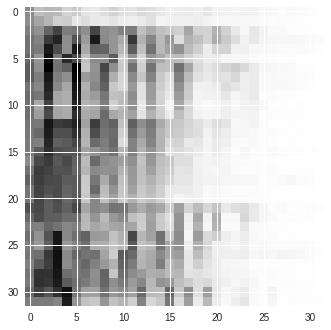

[1. 0. 0.]


In [0]:
#Print sample image and its label
print(competition_dataset.shape)
num_of_sample = 1

plt.imshow(competition_dataset[num_of_sample][0])
plt.show()
print(competition_dataset_labels[num_of_sample])

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
from tensorflow import keras 
import tensorflow as tf
import random
from keras.models import Sequential
from keras.layers import Activation
from keras.optimizers import SGD
from keras.constraints import maxnorm
import sklearn.metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Convolution2D, Conv2D, MaxPooling2D, Lambda, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization,GaussianNoise, Activation, AveragePooling2D, Concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import np_utils
from keras import regularizers

In [0]:
#Shuffle and split
x = competition_dataset
y = competition_dataset_labels
x_1 = competition_test
y_1 = competition_mypredict.drop(columns=['id'])
x = np.vstack((x,x_1))
y = np.vstack((y,y_1))


combined = list(zip(x, y))
random.shuffle(combined)
x[:], y[:] = zip(*combined)

split = len(x)//7

x_test = x[:split]
x_train = x[split:]
y_test = y[:split]
y_train = y[split:]






In [0]:
#other type
def model3():
  weight_decay = 1e-4
  model = Sequential()
  model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(1, 32, 32),data_format = "channels_first"))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(3, activation='softmax'))

  adam = tf.train.AdamOptimizer()
  model.compile(loss='categorical_crossentropy',
                optimizer=adam,
                metrics=['top_k_categorical_accuracy'])
  return model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 32, 30, 30)        320       
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 30, 28, 64)        17344     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 15, 14, 64)        0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 15, 14, 64)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 13, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 4, 4, 128)         147584    
__________

In [0]:
#mytype
def model2():
  weight_decay = 1e-4
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizers.l2(weight_decay),data_format = "channels_first", input_shape=(1, 32, 32)))
  model.add(BatchNormalization())

  model.add(Conv2D(64, kernel_size=(3, 3),kernel_regularizer=regularizers.l2(weight_decay), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(256, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(3, activation='softmax'))
  # Train model
  adam = tf.train.AdamOptimizer()
  model.compile(loss='categorical_crossentropy',
                optimizer=adam,
                metrics=['top_k_categorical_accuracy'])
  return model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 32, 30, 30)        320       
_________________________________________________________________
batch_normalization_23 (Batc (None, 32, 30, 30)        120       
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 30, 28, 64)        17344     
_________________________________________________________________
batch_normalization_24 (Batc (None, 30, 28, 64)        256       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 15, 14, 64)        0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 15, 14, 64)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 13, 12, 128)       73856     
__________

In [0]:
def model1():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',data_format = "channels_first", input_shape=(1, 32, 32)))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(3, activation='softmax'))
  # Train model
  adam = tf.train.AdamOptimizer()
  model.compile(loss='categorical_crossentropy',
                optimizer=adam,
                metrics=['top_k_categorical_accuracy'])
  return model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 32, 30, 30)        320       
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 30, 28, 64)        17344     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 15, 14, 64)        0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 15, 14, 64)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 13, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 4, 4, 128)         147584    
__________

In [0]:
'''
score[0] = 1
for i in range(100):
  if score[0]<0.000001:
    break
  model = model1()
  j = 0
  while(score[0]>0.000001):

    model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 24, verbose=2, epochs=10)

    #evaluate on unseen data
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))
    if j >15:
      break
      
'''
#model = model1()
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 24, verbose=2, epochs=30)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Train on 2768 samples, validate on 308 samples
Epoch 1/30
 - 2s - loss: 0.0780 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0840 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/30
 - 1s - loss: 0.0780 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1285 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/30
 - 1s - loss: 0.0760 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0723 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/30
 - 1s - loss: 0.0699 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0712 - val_top_k_categorical_accuracy: 1.0000
Epoch 5/30
 - 1s - loss: 0.0614 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0661 - val_top_k_categorical_accuracy: 1.0000
Epoch 6/30
 - 1s - loss: 0.0613 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0929 - val_top_k_categorical_accuracy: 1.0000
Epoch 7/30
 - 1s - loss: 0.0624 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0938 - val_top_k_categorical_accuracy: 1.0000
Epoch 8/30
 - 1s - loss: 0.0551 - top_k_categorica

Confusion matrix, without normalization
[[174   2   0]
 [  5 192   4]
 [  0   0 135]]
0.9792783495763455


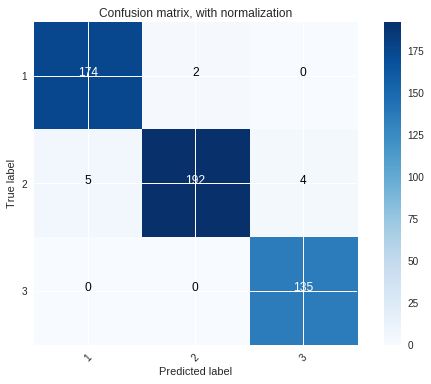

In [0]:
y_pred = model.predict(x_test)
matrix = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
plot_confusion_matrix(matrix,normalize = False, 
                          classes = ['1','2','3'], 
                          title='Confusion matrix, with normalization')
val_f1 = sklearn.metrics.f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1),average  = 'macro')
print (val_f1)
com_pred_label = model.predict(competition_test)
final_predict = com_pred_label.argmax(axis=1)
id = list(range(1,(len(com_pred_label)+1)))
df1 = pd.DataFrame(
    {'id': id,
     'class': final_predict
    })
#df1 = pd.DataFrame(
#    {'id': id,
#     'class1prob': com_pred_label[:,0],
#     'class2prob': com_pred_label[:,1],
 #    'class3prob': com_pred_label[:,2]
 #   })

In [0]:
df1.to_csv('final21.csv',index = False)